In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

# PySpark specific imports
from pyspark.sql.functions import col, isnan, when, count

# Special version of pandas for spark
from pyspark import pandas as ps
ps.set_option('display.max_rows', 10)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/02 19:48:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/03/02 19:48:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Self Defined functions (for code re-usability)

In [2]:
def union_all(dfs: list):
    '''
    combines multiple Spark DataFrames in a given list

    input: a list of Spark DataFrames
    output: a single/unified Spark DataFrames
    '''
    return reduce(lambda df1, df2: df1.union(df2.select(df1.columns)), dfs)

def shape_df(a_spark_dataframe) -> tuple:
    '''
    input: a Spark data frame
    output: shape of the DataFrame (as a tuple of row & col --> (#rows, #cols) )
    '''
    return (a_spark_dataframe.count(), len(a_spark_dataframe.columns))

def cast_col_type(a_spark_df, col_list: list, new_type: str):
    ''''
    input: 
        1. a pyspark dataframe (to be used as reference)
        2. a list of col names (to convert their value types)
        3. new type (to convert values to)
            e.g., 'integer', 'float', 'string', 'double', and etc.
    output: a DataFrame with the specified col type changed new_type
    '''
    return a_spark_df.select(
        *[c for c in a_spark_df.columns if c not in col_list], 
        *[col(feat).cast(new_type).alias(feat) for feat in col_list]
        )

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('bigdata_final_project_EDA').getOrCreate()
spark

### Import Dataset
- import each chunk individually
- combine all chunks together

#### import all dataset chunks

In [4]:
df1 = spark.read.csv('./Data/block_1.csv', header=True, inferSchema=True)
df2 = spark.read.csv('./Data/block_2.csv', header=True, inferSchema=True)
df3 = spark.read.csv('./Data/block_3.csv', header=True, inferSchema=True)
df4 = spark.read.csv('./Data/block_4.csv', header=True, inferSchema=True)
df5 = spark.read.csv('./Data/block_5.csv', header=True, inferSchema=True)
df6 = spark.read.csv('./Data/block_6.csv', header=True, inferSchema=True)
df7 = spark.read.csv('./Data/block_7.csv', header=True, inferSchema=True)
df8 = spark.read.csv('./Data/block_8.csv', header=True, inferSchema=True)
df9 = spark.read.csv('./Data/block_9.csv', header=True, inferSchema=True)
df10 = spark.read.csv('./Data/block_10.csv', header=True, inferSchema=True)

#### combine all chunks of dataset into one cohesive unit

In [5]:
df_list = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]

# combine all chunks of dataset into one cohesive unit
df = union_all(df_list)
df.show()

+-----+-----+-----------------+------------+------------+------------+-------+------+------+------+-------+--------+
| id_1| id_2|     cmp_fname_c1|cmp_fname_c2|cmp_lname_c1|cmp_lname_c2|cmp_sex|cmp_bd|cmp_bm|cmp_by|cmp_plz|is_match|
+-----+-----+-----------------+------------+------------+------------+-------+------+------+------+-------+--------+
|37291|53113|0.833333333333333|           ?|         1.0|           ?|      1|     1|     1|     1|      0|    true|
|39086|47614|                1|           ?|         1.0|           ?|      1|     1|     1|     1|      1|    true|
|70031|70237|                1|           ?|         1.0|           ?|      1|     1|     1|     1|      1|    true|
|84795|97439|                1|           ?|         1.0|           ?|      1|     1|     1|     1|      1|    true|
|36950|42116|                1|           ?|         1.0|           1|      1|     1|     1|     1|      1|    true|
|42413|48491|                1|           ?|         1.0|       

#### Cleaning the Dataset
- replace "?" signes with Null values
- convert (cast) all col types with new (correct) type
- 

#### replace "?" signes with Null values

In [6]:
# replace ? with Null values
# as ? is not known as missing value to pyspark
df_with_null = df.na.replace('?', None)

print('the shape of the dataset (before preprocessing):', shape_df(df_with_null))
df_with_null.show()
df_with_null.printSchema()

the shape of the dataset (before preprocessing): (5749132, 12)
+-----+-----+-----------------+------------+------------+------------+-------+------+------+------+-------+--------+
| id_1| id_2|     cmp_fname_c1|cmp_fname_c2|cmp_lname_c1|cmp_lname_c2|cmp_sex|cmp_bd|cmp_bm|cmp_by|cmp_plz|is_match|
+-----+-----+-----------------+------------+------------+------------+-------+------+------+------+-------+--------+
|37291|53113|0.833333333333333|        null|         1.0|        null|      1|     1|     1|     1|      0|    true|
|39086|47614|                1|        null|         1.0|        null|      1|     1|     1|     1|      1|    true|
|70031|70237|                1|        null|         1.0|        null|      1|     1|     1|     1|      1|    true|
|84795|97439|                1|        null|         1.0|        null|      1|     1|     1|     1|      1|    true|
|36950|42116|                1|        null|         1.0|           1|      1|     1|     1|     1|      1|    true|
|

#### convert (cast) all col types with new (correct) type

In [7]:
# print the value type of each feat/col
# as we see the Schemas are not correct
# e.g., we have string for cmp_fname_c1 which must be 'float'/'double'
print('\n','Before type conversion'.center(79, "-"))
df_with_null.printSchema()

# make the cmp_fname_c1|cmp_fname_c2|cmp_lname_c1|cmp_lname_c2 cols double_precision float
df_new_type_1 = cast_col_type(df_with_null, df.columns[2:6], 'double')
# df_new_type_1.show(21000)
# df_new_type_1.printSchema()

# make the cmp_sex|cmp_bd|cmp_bm|cmp_by|cmp_plz|is_match cols integer
df_new_type_2 = cast_col_type(df_new_type_1, df.columns[6:11], 'int')
# df_new_type_2.show(21000)
# df_new_type_2.printSchema()

# make the labels/classes binary (0, 1) instead of True/False
df_new_type_3 = cast_col_type(df_new_type_2, ['is_match'], 'integer')
# df_new_type_3.show(21000)
# df_new_type_3.printSchema()

df_new_type_final = df_new_type_3
print('\n','After type conversion'.center(79, "-"))
df_new_type_final.printSchema()


 -----------------------------Before type conversion----------------------------
root
 |-- id_1: integer (nullable = true)
 |-- id_2: integer (nullable = true)
 |-- cmp_fname_c1: string (nullable = true)
 |-- cmp_fname_c2: string (nullable = true)
 |-- cmp_lname_c1: double (nullable = true)
 |-- cmp_lname_c2: string (nullable = true)
 |-- cmp_sex: integer (nullable = true)
 |-- cmp_bd: string (nullable = true)
 |-- cmp_bm: string (nullable = true)
 |-- cmp_by: string (nullable = true)
 |-- cmp_plz: string (nullable = true)
 |-- is_match: boolean (nullable = true)


 -----------------------------After type conversion-----------------------------
root
 |-- id_1: integer (nullable = true)
 |-- id_2: integer (nullable = true)
 |-- cmp_fname_c1: double (nullable = true)
 |-- cmp_fname_c2: double (nullable = true)
 |-- cmp_lname_c1: double (nullable = true)
 |-- cmp_lname_c2: double (nullable = true)
 |-- cmp_sex: integer (nullable = true)
 |-- cmp_bd: integer (nullable = true)
 |-- cmp_bm:

## EDA

### Report ratio/freq of NaN/Null values
- this way we can identify the feats with a high number of missing values (and remove them for good)

#Null values in "is_match" col:  0

#NaN or #Null values in each col


,id_1,id_2,cmp_fname_c1,cmp_fname_c2,cmp_lname_c1,cmp_lname_c2,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz
0,0,0,1007,5645434,0,5746668,0,795,795,795,12843


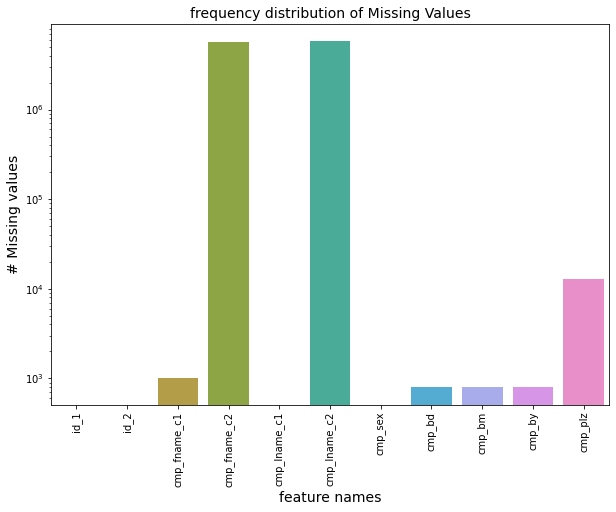

In [8]:
# calc the #Null values in "is_match" col
# to make sure each & every record has a label/class
from pyspark.sql.functions import col
count_1 = df_new_type_final.filter(col('is_match').isNull()).count()
print('#Null values in "is_match" col: ', count_1)

# show the #NaN or #Null values in other cols
from pyspark.sql.functions import col,isnan, when, count
print('\n#NaN or #Null values in each col')
count_2 = df_new_type_final.select(
    [count(when(isnan(c) | col(c).isNull(), c)).alias(c)
     for c in df.columns if c != 'is_match']
)

display(count_2.toPandas())
# sns.set_theme(style="darkgrid")
# ax = sns.countplot(x=, data=count_2)

# count_2_freq_dist_null = pd.DataFrame(count_2.collect()[0], columns=['freq'], index=count_2.columns)
count_2_freq_dist_null = pd.Series(count_2.collect()[0], index=count_2.columns)
# display(count_2_freq_dist_null)

# Returns the histogram of Missing values
fig, ax = plt.subplots(figsize=(10, 7))
label_font_size = 14
plt.ylabel('# Missing values', fontsize=label_font_size)
plt.xlabel('feature names', fontsize=label_font_size)
plt.title('frequency distribution of Missing Values', fontsize=label_font_size)
plt.xticks(rotation=90)
# ax = sns.histplot(data=count_2_freq_dist_null, ax=ax)
ax = sns.barplot(
    x=count_2_freq_dist_null.index, 
    y=count_2_freq_dist_null.values, 
    # hue=count_2_freq_dist_null.index
    )
ax.set_yscale("log")
plt.show()

#### Using Spark's version of Pandas to be used with Seaborn, Matplotlib, and etc. for EDA

In [9]:
# method 1 (results in multiple data chunks)
# df_pandas_eda = ps.DataFrame(df_new_type_final)
# df_pandas_eda.to_csv('df_panas_eda', index=0)
# df_pandas_eda

# method 2 (one single .csv file)
# first export the csv files then rename it to "df_pandas_eda"
# then uncomment this line and execute the pd.read_csv line 
# df_new_type_final.coalesce(1).write.csv("df_pandas_eda")

df_pandas_eda = pd.read_csv("./df_pandas_eda.csv", names=df_new_type_final.columns)
df_pandas_eda

,id_1,id_2,cmp_fname_c1,cmp_fname_c2,cmp_lname_c1,cmp_lname_c2,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz,is_match
0,37291,53113,0.833333,NaN,1.000000,NaN,1,1.0,1.0,1.0,0.0,1
1,39086,47614,1.000000,NaN,1.000000,NaN,1,1.0,1.0,1.0,1.0,1
2,70031,70237,1.000000,NaN,1.000000,NaN,1,1.0,1.0,1.0,1.0,1
3,84795,97439,1.000000,NaN,1.000000,NaN,1,1.0,1.0,1.0,1.0,1
4,36950,42116,1.000000,NaN,1.000000,1.0,1,1.0,1.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5749127,32517,73116,1.000000,NaN,0.222222,NaN,1,0.0,1.0,0.0,0.0,0
5749128,67707,83757,0.111111,NaN,1.000000,NaN,1,0.0,0.0,0.0,0.0,0
5749129,53258,91808,1.000000,NaN,0.000000,NaN,1,0.0,0.0,1.0,0.0,0
5749130,31865,85285,1.000000,NaN,0.111111,NaN,1,0.0,1.0,0.0,0.0,0


#### Statistic Analysis of Dataset

In [10]:
display(df_pandas_eda.loc[:, 'cmp_fname_c1':'cmp_plz'].describe().round(2))

,cmp_fname_c1,cmp_fname_c2,cmp_lname_c1,cmp_lname_c2,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz
count,5748125.00,103698.00,5749132.00,2464.00,5749132.00,5748337.00,5748337.00,5748337.00,5736289.00
mean,0.71,0.90,0.32,0.32,0.96,0.22,0.49,0.22,0.01
std,0.39,0.27,0.33,0.37,0.21,0.42,0.50,0.42,0.07
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.29,1.00,0.10,0.00,1.00,0.00,0.00,0.00,0.00
50%,1.00,1.00,0.18,0.17,1.00,0.00,0.00,0.00,0.00
75%,1.00,1.00,0.43,0.38,1.00,0.00,1.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


#### Report the Missing Values (Numerically + Graphically)

,id_1,id_2,cmp_fname_c1,cmp_fname_c2,cmp_lname_c1,cmp_lname_c2,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz,is_match
0,0,0,1007,5645434,0,5746668,0,795,795,795,12843,0


'number of rows with missing values:'

5749112

'total number of missing values in dataset'

11408337

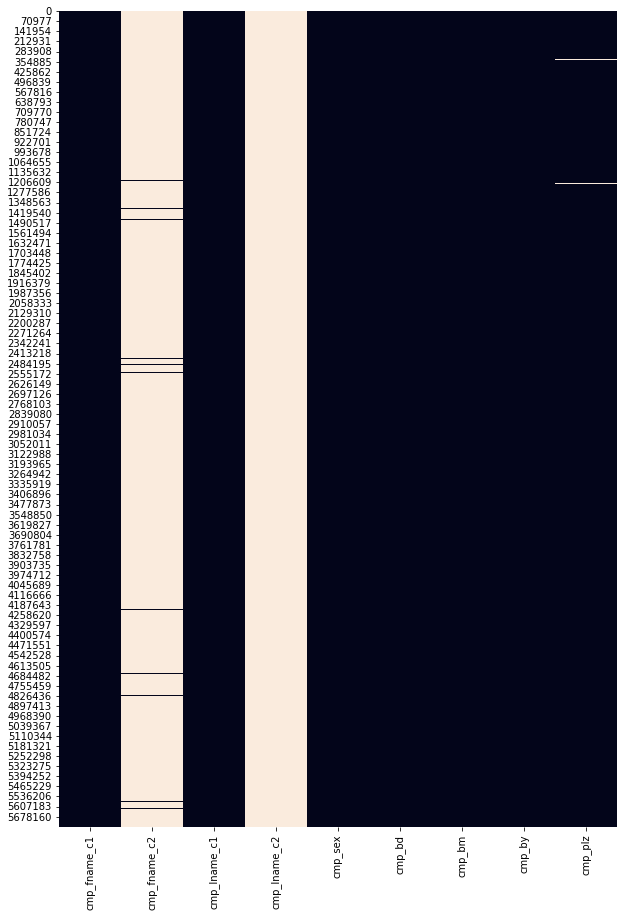

In [11]:
# count the number of Missing values (NaN) per col
display(pd.DataFrame(df_pandas_eda.isnull().sum()).transpose())

display('number of rows with missing values:', (df_pandas_eda.isnull().any(axis=1)).sum())

# count the number of Missing values (NaN) for all cols
display('total number of missing values in dataset', df_pandas_eda.isnull().sum().sum())

# plot the Missing values
# to show we did good in spreading the missing values in all features with balance
# set the plot size
fig, ax = plt.subplots(figsize=(10, 15))
sns.heatmap(df_pandas_eda.loc[:, 'cmp_fname_c1':'cmp_plz'].isnull(), cbar=False, ax=ax)
plt.show()

#### Correlations between independent variables.
> as there are no "highly correlated" features we have to keep them all.

##### 1. Correlation between numerical real valued feats

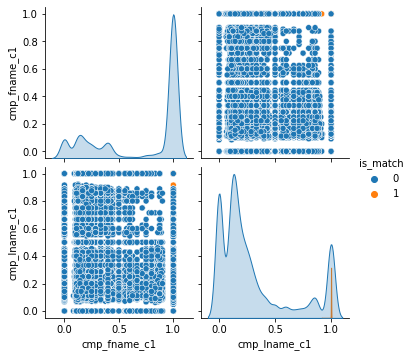

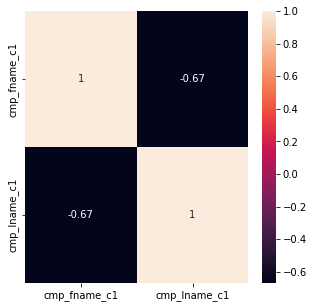

In [26]:
# pair plot of correlation
sns_plot = sns.pairplot(df_pandas_eda.iloc[:, [2, 4, 11]].sample(
    100000), hue='is_match', height=2.5)
# sns_plot.savefig("pairplot.pdf")
plt.show()

# heatmap of correlation
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.heatmap(df_pandas_eda.iloc[:, [2, 4]].corr(), annot=True, ax=ax)
plt.show()


##### 2. Correlation between numerical binary valued feats

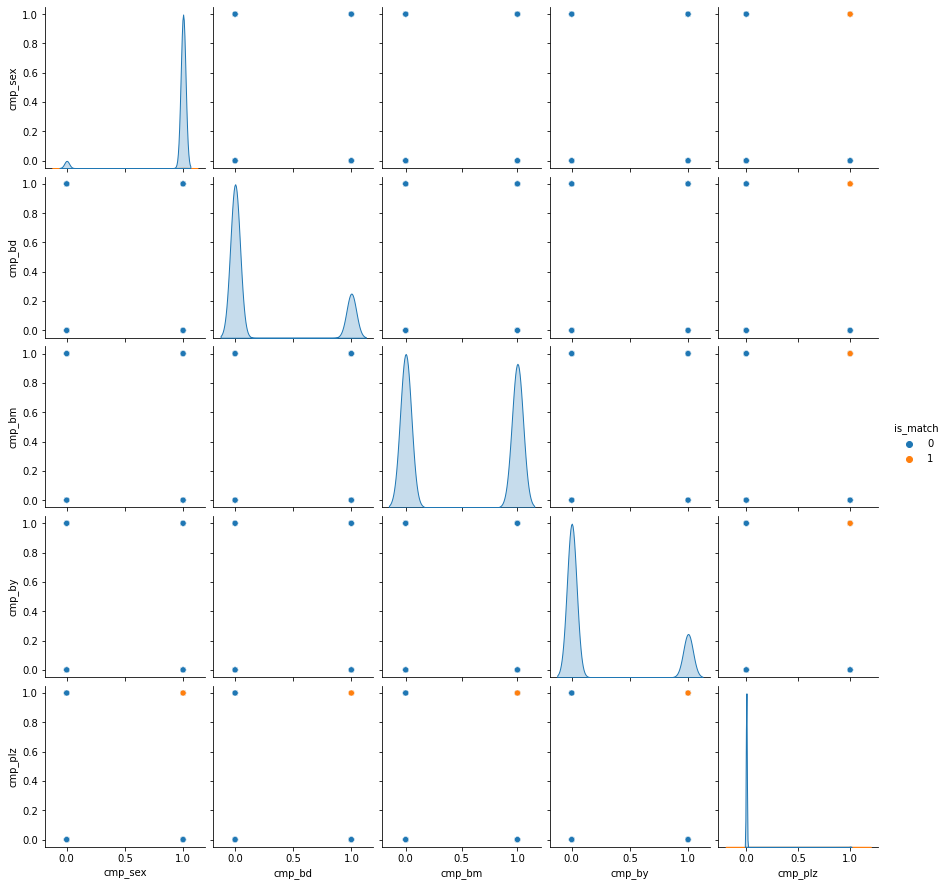

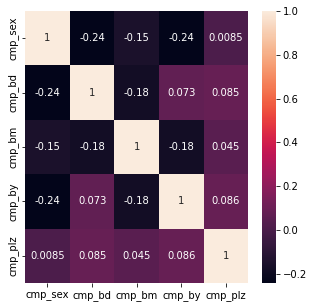

In [27]:
# pair plot of correlation
sns_plot = sns.pairplot(df_pandas_eda.iloc[:, [6,7,8,9,10,11]].sample(100000), hue='is_match', height=2.5)
# sns_plot.savefig("pairplot.pdf")
plt.show()

# heatmap of correlation
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.heatmap(df_pandas_eda.iloc[:, [6,7,8,9,10]].corr(), annot=True, ax=ax)
plt.show()

### Box-and-Whisker Plot
- \* we didn't included other predictive (i.e., cmp_sex, cmp_bd, and etc.) features as their were binary (0, 1)

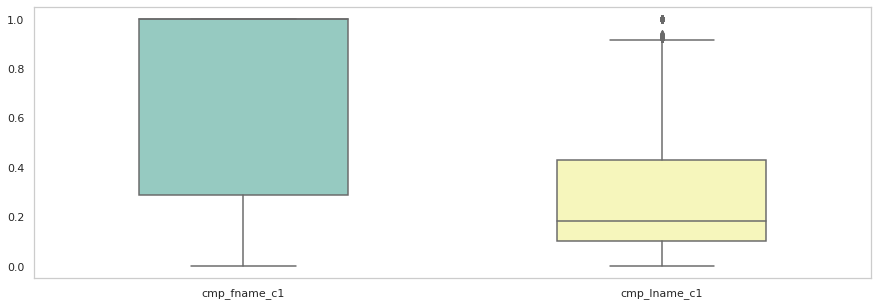

In [32]:
# set the plot configs
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(15, 5))
# remove grids
ax.grid(False)
# *** we didn't included other predictive features as their were binary (0, 1)
ax = sns.boxplot(data=df_pandas_eda.loc[:, ['cmp_fname_c1','cmp_lname_c1']], palette="Set3", ax=ax, width=.5)
plt.show()

### Plotting Distribution labels
- note that the numbers of classes are highly unbalanced (asymmetric)

/home/tekboart/.pyenv/versions/3.9.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


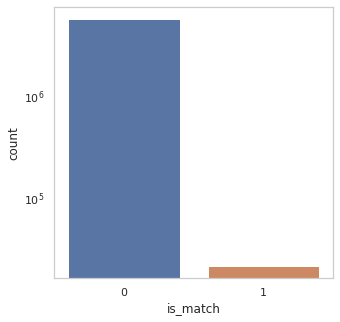

,0,1
is_match,5728201,20931


In [34]:
# Plot distribution
fig, ax = plt.subplots(figsize=(5, 5))
# remove grids
ax.grid(False)

# sns.countplot(df_pandas_eda['is_match'].sort_values() ax=ax)
ax = sns.countplot(df_pandas_eda['is_match'], ax=ax)
ax.set_yscale("log")
plt.show()

display(pd.DataFrame(df_pandas_eda['is_match'].value_counts().sort_index()).transpose())